# Autoencoder

## 1. Autoencoder with linear layer

Import library

In [249]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt

Get the MNIST dataset

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([ToTensor()])
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([ToTensor()])
)

In [314]:
BATCH_SIZE = 64

# Create dataloader
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in test_dl:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [271]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Create model

In [272]:
class MyFirstEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.act_fn = nn.ReLU()
        self.linear_layer = nn.Sequential(
            nn.Linear(28*28, 512),
            self.act_fn,
            nn.Linear(512, 256),
            self.act_fn,
            nn.Linear(256, 100),
            self.act_fn,
            nn.Linear(100, 30)
        )
    def forward(self, x):
        #print(x.shape)
        x = self.flatten(x)
        x = self.linear_layer(x)
        #print(x.shape)
        return x

class MyFirstDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_fn = nn.ReLU()
        self.linear_layer = nn.Sequential(
            nn.Linear(30, 100),
            self.act_fn,
            nn.Linear(100, 256),
            self.act_fn,
            nn.Linear(256, 512),
            self.act_fn,
            nn.Linear(512, 28*28)
        )
    def forward(self, x):
        x = self.linear_layer(x)
        #print(x.shape)
        x = torch.reshape(x, (-1, 1, 28, 28))
        #print(x.shape)
        return x

class MyFirstAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MyFirstEncoder()
        self.decoder = MyFirstDecoder()
        
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [273]:
model1 = MyFirstAutoencoder().to(device)

In [274]:
from torchsummary import summary
summary(model1, input_size=(1,28,28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 30]           3,030
   MyFirstEncoder-12                   [-1, 30]               0
           Linear-13                  [-1, 100]           3,100
             ReLU-14                  [

In [291]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=20, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # (28, 28)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1), 
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (14, 14)
            act_fn,
            nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (7, 7)
            act_fn,
            nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(4*out_channels*7*7, latent_dim),
            act_fn
        )
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.net(x)
        return x
class CNNDecoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=20, act_fn=nn.ReLU()):
        super().__init__()
    
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (7, 7)
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                               stride=2, output_padding=1), # (14, 14)
            act_fn,
            nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                               stride=2, output_padding=1), # (28, 28)
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
        )
    
    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 4*self.out_channels, 7, 7)
        output = self.conv(output)
        return output
    
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [292]:
model2 = CNNAutoencoder().to(device)

In [293]:
summary(model2, input_size=(1,28,28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
             ReLU-12             [-1, 64, 7, 7]               0
          Flatten-13                 [-1, 3136]               0
           Linear-14                   

Define loss and optimizer

In [295]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(),
                            lr=1e-3)

Create train and test step

In [296]:
import torch.utils
import torch.utils.data


def train_step(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = "cpu"):
    size = len(dataloader.dataset)
    
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        # 1. Forward
        logits = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(logits, X)
        total_loss += loss
        
        # 3. Backpropagation
        loss.backward()
        
        # 4. Optimizer step
        optimizer.step()
        
        # 5. Zero grad
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= len(dataloader)
    return total_loss

def test_step(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn,
               device: torch.device = "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    
    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
        
        

In [297]:
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

In [298]:
epochs = 20

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_step(dataloader=train_dl,
                            model=model2,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
    test_loss, accuracy = test_step(dataloader=test_dl,
                            model=model2,
                            loss_fn=loss_fn,
                            device=device)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 0.130127  [   64/60000]
loss: 0.065679  [ 6464/60000]
loss: 0.043138  [12864/60000]
loss: 0.040620  [19264/60000]
loss: 0.034448  [25664/60000]
loss: 0.028533  [32064/60000]
loss: 0.025552  [38464/60000]
loss: 0.026951  [44864/60000]
loss: 0.026177  [51264/60000]
loss: 0.023264  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.027617 

Epoch 2
-------------------------------
loss: 0.026067  [   64/60000]
loss: 0.022089  [ 6464/60000]
loss: 0.020535  [12864/60000]
loss: 0.024054  [19264/60000]
loss: 0.023524  [25664/60000]
loss: 0.021606  [32064/60000]
loss: 0.021513  [38464/60000]
loss: 0.022547  [44864/60000]
loss: 0.020518  [51264/60000]
loss: 0.020317  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.023499 

Epoch 3
-------------------------------
loss: 0.021667  [   64/60000]
loss: 0.018361  [ 6464/60000]
loss: 0.018023  [12864/60000]
loss: 0.020249  [19264/60000]
loss: 0.020186  [25664/60000]
loss: 0.019415  [32064/60000

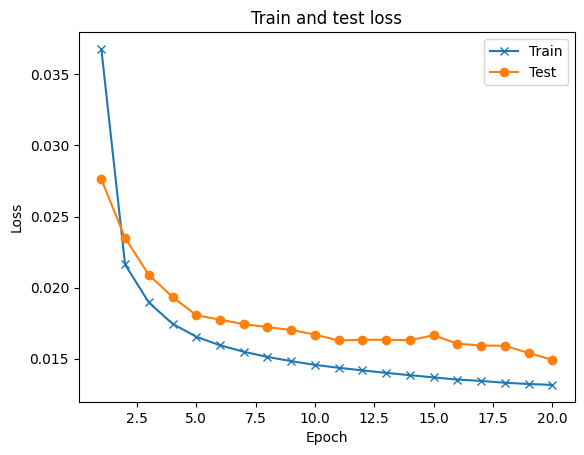

In [299]:
import matplotlib.pyplot as plt
import numpy as np
train_loss_history_tensor = torch.Tensor(train_loss_history).cpu()
test_loss_history_tensor = torch.Tensor(test_loss_history).cpu()
plt.plot(np.arange(1,21), train_loss_history_tensor, marker='x')
plt.plot(np.arange(1,21), test_loss_history_tensor, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss")
plt.legend(["Train", "Test"])

In [300]:
torch.save(model2.state_dict(), "autoencoder_cnn.pth")
print("saved Pytorch model state to the autoencoder_cnn.pth")

saved Pytorch model state to the autoencoder_cnn.pth


In [315]:
model2.eval()
idx = 54

x, y = test_data[idx][0], test_data[idx][1]

x = x[np.newaxis, :]

with torch.inference_mode():
    x = x.to(device)
    pred = model2(x)
    

C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3135132700.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(x[0]).cpu()
C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3135132700.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstruct_image = torch.tensor(pred[0]).cpu()


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


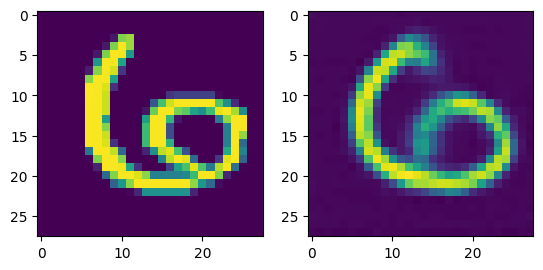

In [316]:
from PIL import Image
plt.subplot(1,2,1)
image = torch.tensor(x[0]).cpu()
reconstruct_image = torch.tensor(pred[0]).cpu()
print(image.shape)
print(reconstruct_image.shape)
plt.imshow(image.reshape(28,28,1))
plt.subplot(1,2,2)
plt.imshow(reconstruct_image.reshape(28,28,1))
plt.savefig(str('autoencoder_linear4.jpg'), bbox_inches='tight')

In [317]:
model2.eval()

with torch.inference_mode():
    random_vector = torch.rand(1, 20).to(device)
    haha = model2.decoder(random_vector)

torch.Size([1, 28, 28])


C:\Users\letha\AppData\Local\Temp\ipykernel_22772\2089459355.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(haha[0]).cpu()


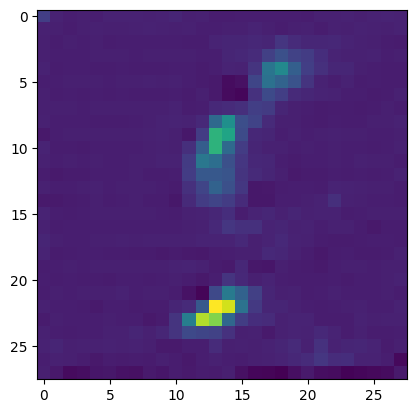

In [318]:
from PIL import Image
image = torch.tensor(haha[0]).cpu()
print(image.shape)
plt.imshow(image.reshape(28,28,1))

In [319]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=2), # 14, 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 7 7
            nn.Flatten(),
            nn.Linear(8*7*7, 56),
            nn.ReLU(),
            nn.Linear(56, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [320]:
discriminator = Discriminator().to(device)

In [321]:
summary(discriminator, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
         MaxPool2d-3              [-1, 8, 7, 7]               0
           Flatten-4                  [-1, 392]               0
            Linear-5                   [-1, 56]          22,008
              ReLU-6                   [-1, 56]               0
            Linear-7                    [-1, 1]              57
           Sigmoid-8                    [-1, 1]               0
Total params: 22,145
Trainable params: 22,145
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.08
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [322]:
adversarial_loss = nn.BCELoss()
generator = CNNAutoencoder().to(device)

optimizer_G = torch.optim.Adam(params=generator.parameters(), lr=1e-4)
optimizer_D = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

In [323]:
from torch.autograd import Variable
from torch import Tensor
epochs = 50
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_dl):
        imgs = imgs.to(device)
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to(device)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 20)))).to(device)

        # Generate a batch of images
        gen_imgs = generator.decoder(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, epochs, i, len(train_dl), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(train_dl) + i
        #if batches_done % opt.sample_interval == 0:
        #    save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/50] [Batch 0/938] [D loss: 0.695317] [G loss: 0.673124]
[Epoch 0/50] [Batch 1/938] [D loss: 0.692888] [G loss: 0.672558]
[Epoch 0/50] [Batch 2/938] [D loss: 0.688983] [G loss: 0.671995]
[Epoch 0/50] [Batch 3/938] [D loss: 0.688412] [G loss: 0.671419]
[Epoch 0/50] [Batch 4/938] [D loss: 0.684261] [G loss: 0.670679]
[Epoch 0/50] [Batch 5/938] [D loss: 0.681443] [G loss: 0.669934]
[Epoch 0/50] [Batch 6/938] [D loss: 0.677754] [G loss: 0.669151]
[Epoch 0/50] [Batch 7/938] [D loss: 0.675601] [G loss: 0.668351]
[Epoch 0/50] [Batch 8/938] [D loss: 0.673099] [G loss: 0.667585]
[Epoch 0/50] [Batch 9/938] [D loss: 0.670934] [G loss: 0.666754]
[Epoch 0/50] [Batch 10/938] [D loss: 0.666841] [G loss: 0.665825]
[Epoch 0/50] [Batch 11/938] [D loss: 0.666178] [G loss: 0.664794]
[Epoch 0/50] [Batch 12/938] [D loss: 0.660860] [G loss: 0.663678]
[Epoch 0/50] [Batch 13/938] [D loss: 0.661240] [G loss: 0.662538]
[Epoch 0/50] [Batch 14/938] [D loss: 0.657517] [G loss: 0.661353]
[Epoch 0/50] [Batch 

torch.Size([1, 28, 28])
tensor([[0.9259]], device='cuda:0')
tensor([[0.2593]], device='cuda:0')


C:\Users\letha\AppData\Local\Temp\ipykernel_22772\687000549.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_image = torch.tensor(fake[0]).cpu()


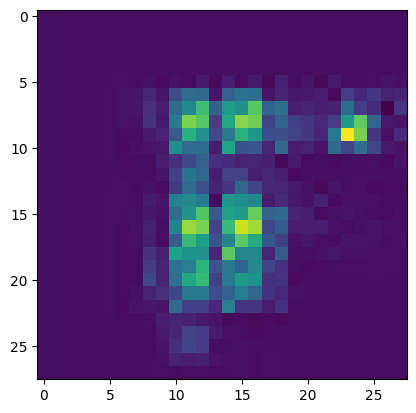

In [330]:
x, y = test_data[idx][0], test_data[idx][1]

x = x[np.newaxis, :]
torch.manual_seed(36)
with torch.inference_mode():
    random_vector = torch.rand(1, 20).to(device)
    fake = generator.decoder(random_vector)
fake_image = torch.tensor(fake[0]).cpu()
print(fake_image.shape)
plt.imshow(fake_image.reshape(28,28,1))
with torch.inference_mode():
    print(discriminator(x.to(device)))
    print(discriminator(fake.to(device)))

C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3167570853.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(x[0]).cpu()
C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3167570853.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstruct_image = torch.tensor(pred[0]).cpu()


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


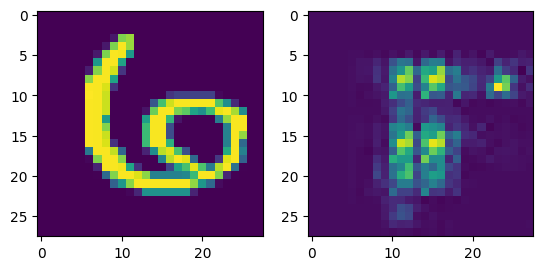

In [326]:
generator.eval()
idx = 54

x, y = test_data[idx][0], test_data[idx][1]

x = x[np.newaxis, :]

with torch.inference_mode():
    x = x.to(device)
    pred = generator(x)

plt.subplot(1,2,1)
image = torch.tensor(x[0]).cpu()
reconstruct_image = torch.tensor(pred[0]).cpu()
print(image.shape)
print(reconstruct_image.shape)
plt.imshow(image.reshape(28,28,1))
plt.subplot(1,2,2)
plt.imshow(reconstruct_image.reshape(28,28,1))
plt.savefig(str('autoencoder_linear4.jpg'), bbox_inches='tight')

In [733]:
import torch
import torch.nn as nn

# Generator: Autoencoder-based CNN
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch, 32, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch, 64, 7, 7)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(128 * 7 * 7, latent_dim),
            nn.ReLU()
        )
    def forward(self, z):
        encoded = self.encoder(z)
        encoded = encoded.view(z.size(0), -1)
        encoded = self.linear_layer(encoded)
        return encoded

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (batch, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # (batch, 32, 28, 28)
            nn.ReLU(inplace=True),
            #nn.Tanh()  # Output in range [-1, 1]
        )
    def forward(self, z):
        z = self.linear_layer(z)
        z = z.view(-1, 128, 7 ,7)
        z = self.decoder(z)
        return z
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.encoder = Encoder(latent_dim=latent_dim)
        
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, z):
        return self.decoder(self.encoder(z))


# Discriminator: CNN + Linear Layer
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch, 128, 7, 7)
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Linear(64 * 7 * 7, 1)  # Linear layer to classify real/fake
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.sigmoid(self.fc(x))


In [840]:
import torch
import torch.nn as nn

# Generator: Autoencoder-based CNN
class EncoderV3(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch, 32, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch, 64, 7, 7)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # batch 256, 7, 7
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(256 * 7 * 7, latent_dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        encoded = self.encoder(z)
        encoded = encoded.view(z.size(0), -1)
        encoded = self.linear_layer(encoded)
        return encoded

class DecoderV3(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(latent_dim, 256 * 7 * 7),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),  # (batch, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (batch, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # (batch, 32, 28, 28)
            nn.ReLU(inplace=True),
            #nn.Tanh()  # Output in range [-1, 1]
        )
    def forward(self, z):
        z = self.linear_layer(z)
        z = z.view(-1, 128, 7 ,7)
        z = self.decoder(z)
        return z
class GeneratorV3(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        
        self.encoder = Encoder(latent_dim=latent_dim)
        
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, z):
        return self.decoder(self.encoder(z))


# Discriminator: CNN + Linear Layer
class DiscriminatorV3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch, 128, 7, 7)
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Linear(64 * 7 * 7, 1)  # Linear layer to classify real/fake
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.sigmoid(self.fc(x))


In [843]:
# Initialize models
epochs = 50
latent_dim = 30
lr = 0.0002
beta1, beta2 = 0.5, 0.999
generator = GeneratorV3(latent_dim).to("cuda")
discriminator = DiscriminatorV3().to("cuda")

#generator.load_state_dict(torch.load("second_version/gan_generator200.pth", weights_only=True))
#discriminator.load_state_dict(torch.load("second_version/gan_discriminator200.pth", weights_only=True))

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
from torch.autograd import Variable
from torch import Tensor


for epoch in range(110, 151):
    for i, (imgs, _) in enumerate(train_dl):
        imgs = imgs.to(device)
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to(device)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor)).to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))).to(device)

        # Generate a batch of images
        gen_imgs = generator.decoder(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 150, i, len(train_dl), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(train_dl) + i
        #if batches_done % opt.sample_interval == 0:
        #    save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    if (epoch%10==0):
        torch.save(discriminator.state_dict(), f"third_version/gan_discriminator{epoch}.pth")
        print(f"saved Pytorch model state to the third_version/gan_discriminator{epoch}.pth")
        torch.save(generator.state_dict(), f"third_version/gan_generator{epoch}.pth")
        print(f"saved Pytorch model state to the third_version/gan_generator{epoch}.pth")

[Epoch 110/150] [Batch 0/938] [D loss: 0.693238] [G loss: 0.746882]
[Epoch 110/150] [Batch 1/938] [D loss: 0.691802] [G loss: 0.678946]
[Epoch 110/150] [Batch 2/938] [D loss: 0.681713] [G loss: 0.717028]
[Epoch 110/150] [Batch 3/938] [D loss: 0.688363] [G loss: 0.687129]
[Epoch 110/150] [Batch 4/938] [D loss: 0.687971] [G loss: 0.698160]
[Epoch 110/150] [Batch 5/938] [D loss: 0.693433] [G loss: 0.703232]
[Epoch 110/150] [Batch 6/938] [D loss: 0.681425] [G loss: 0.699789]
[Epoch 110/150] [Batch 7/938] [D loss: 0.691793] [G loss: 0.704997]
[Epoch 110/150] [Batch 8/938] [D loss: 0.697907] [G loss: 0.705025]
[Epoch 110/150] [Batch 9/938] [D loss: 0.694913] [G loss: 0.706030]
[Epoch 110/150] [Batch 10/938] [D loss: 0.686850] [G loss: 0.698854]
[Epoch 110/150] [Batch 11/938] [D loss: 0.679920] [G loss: 0.729537]
[Epoch 110/150] [Batch 12/938] [D loss: 0.705023] [G loss: 0.715493]
[Epoch 110/150] [Batch 13/938] [D loss: 0.683541] [G loss: 0.654646]
[Epoch 110/150] [Batch 14/938] [D loss: 0.69

C:\Users\letha\AppData\Local\Temp\ipykernel_22772\2571216705.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_image = torch.tensor(fake[0]).cpu()


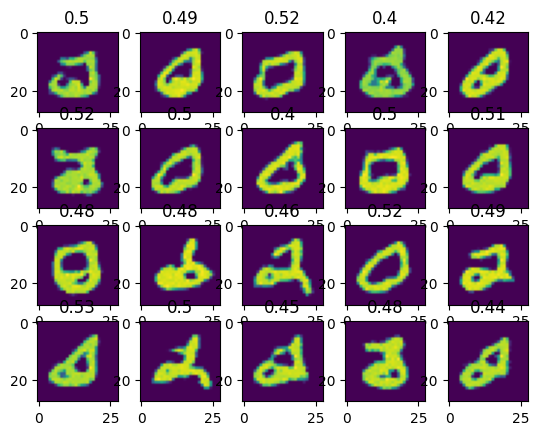

In [881]:
# x, y = test_data[idx][0], test_data[idx][1]
latent_dim = 30
model_test = GeneratorV3(latent_dim).to(device)
model_test.load_state_dict(torch.load("third_version/gan_generator150.pth", weights_only=True))
discriminator_test = DiscriminatorV3().to(device)
discriminator_test.load_state_dict(torch.load("third_version/gan_discriminator150.pth", weights_only=True))
# x = x[np.newaxis, :]
#torch.manual_seed()
with torch.inference_mode():
    for i in range (20):
        random_vector = torch.rand(1, latent_dim).to(device)
        #print(random_vector)
        fake = model_test.decoder(random_vector)
        fake_image = torch.tensor(fake[0]).cpu()
        #print(fake_image.shape)
        plt.subplot(4, 5, i+1)
        plt.imshow(fake_image.reshape(28,28,1))
        plt.title(round(discriminator_test(fake.to(device)).item(), 2))
        #print(discriminator(x.to(device)))
        #print(discriminator(fake.to(device)))

In [748]:
torch.save(discriminator.state_dict(), f"second_version/gan_discriminator{epoch+1}.pth")
print("saved Pytorch model state to the gan_discriminator4.pth")
torch.save(generator.state_dict(), f"second_version/gan_generator{epoch+1}.pth")
print("saved Pytorch model state to the gan_generator4.pth")

saved Pytorch model state to the gan_discriminator4.pth
saved Pytorch model state to the gan_generator4.pth


tensor([[0.4852]], device='cuda:0')


C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3435317682.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_image = torch.tensor(fake[0]).cpu()


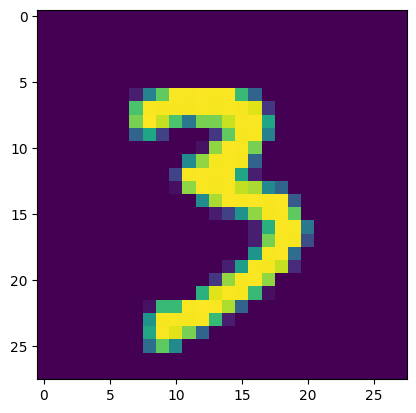

In [835]:
idx = 30
x, y = test_data[idx][0], test_data[idx][1]

x = x[np.newaxis, :]
torch.manual_seed(36)
with torch.inference_mode():
    random_vector = torch.rand(1, 20).to(device)
    fake = generator.decoder(random_vector)
fake_image = torch.tensor(fake[0]).cpu()
#print(fake_image.shape)
plt.imshow(x[0].reshape(28,28,1))
with torch.inference_mode():
    print(discriminator_test(x.to(device)))
    #print(discriminator(fake.to(device)))